# Image Classification

데이터를 ImageDataGenerator를 이용해 모델이 데이터를 효율적으로 활용할 수 있도록 구현해보는게 목적입니다.

* Data augmentation을 이용해 오버피팅을 방지해봅시다.

기본적인 머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.

## Project 설명
### Task
* 적은 수의 강아지와 고양이 사진을 이용해 classification을 진행해보자.
* 주어진 데이터를 Augmentation 하는 법과 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [TensorFlow tutorials/Image classification](https://www.tensorflow.org/tutorials/images/classification).
* 데이터셋은 학습 데이터엔 강아지, 고양이 이미지 1000장이 있고, 테스트용 데이터에는 각각 500장씩 주어져있습니다.
    * 트레이닝 시 image size 조절해 사용

### Baseline
* 기본적으로 사용하는 Convolution layers를 구성해 사용해보자.
    * ex) (Conv - Conv - pooling) * n 개 - FC layers
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
    * Data Augmentation, Dropout, Batch Normalization
* Training
    * tf.data.Dataset 과 model.fit()을 사용
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.
* 모델 저장을 위해서 구글 드라이브를 마운트해줍니다.

In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.15.0'

In [41]:
use_colab = True
assert use_colab in [True, False]

### 데이터셋 다운로드

* 해당 데이터는 개와 고양이 데이터로 구성되어 있습니다.

In [42]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [43]:
PATH

'/root/.keras/datasets/cats_and_dogs_filtered'

### cats_and_dogs_filtered
* |__ train
    * |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    * |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
* |__ validation
    * |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    * |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]

# 데이터셋 설정
* 다운로드 받은 데이터셋에 대한 경로를 이용하여, 데이터를 이용할 준비를 진행합니다.

In [44]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(train_dir, validation_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train /root/.keras/datasets/cats_and_dogs_filtered/validation


In [45]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print(train_cats_dir)

# directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print(validation_dogs_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


* 데이터셋의 구성을 살펴봅시다.

In [46]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


* 학습 데이터는 고양이와 강아지 이미지 각각 1000 장씩으로 구성되어있습니다.
* 모델 평가를 위해서 각각 500장씩을 validation dataset으로 사용합니다.

### 하이퍼파라미터 설정

* 모델 학습을 위한 하이퍼파라미터를 설정한다.
* 하이퍼파라미터는 학습에 중요한 역할을 하기 때문에 신중히 설정해야된다.

In [47]:
batch_size = 32
epochs = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224


### Data preparation 데이터 준비

1. 저장된 images를 읽어온다.
2. RGB content 로 데이터를 디코드 한다.
3. floating point tensor로 변환한다.
4. 0 ~ 255 -> 0 ~ 1 값으로 rescale 한다.

* Data augmentation은 우리가 가진 데이터가 부족하기 때문에 데이터가 많은 것처럼 동작시키는 방법입니다.
* ImageDataGenerator 함수를 이용할 예정이며 해당 함수의 파라미터는 아래에서 확인할 수 있습니다.
* [함수 상세 보기](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [48]:
# 데이터셋에 저장된 이미지를 출력하는 함수
# 이미지 확인을 위해 사용한다.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [49]:
# Generator for our training data
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.1,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=False)

In [50]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


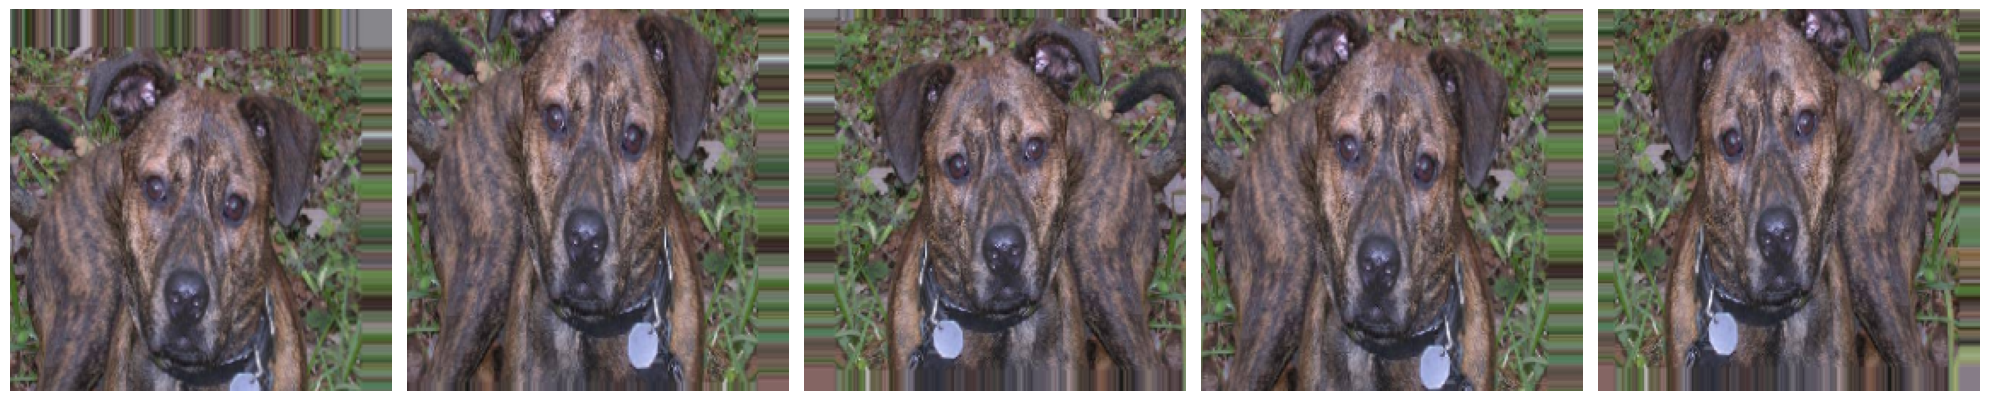

In [51]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [52]:
# Generator for our validation data
image_gen_val = ImageDataGenerator(rescale=1./255)

In [53]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


### 이미지 샘플 확인

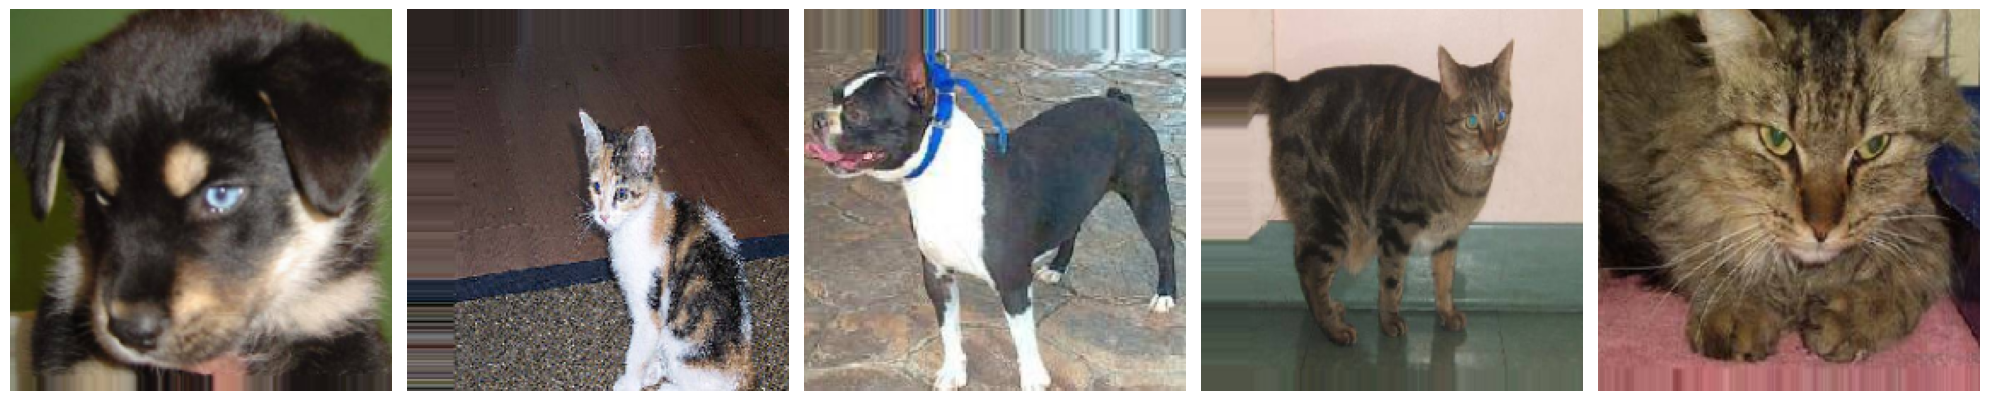

In [54]:
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [55]:
_[:5] # 정답 데이터

array([1., 0., 1., 0., 0.], dtype=float32)

# 모델 생성


In [56]:
model = Sequential()
model.add(Dense(1, activation='linear'))


### Complie the model

* 학습을 위한 optimizer, loss를 설정합니다.

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # 0.0001~0.000001
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 모델 학습 진행
* 학습을 진행할때, train과 valid 데이터셋을 이용하여 학습과 검증을 동시에 진행합니다.
* 각 데이터셋은 위에서 구성했기 때문에, 모델에서 사용할 데이터의 step의 길이를 batch_size를 이용해 계산해줍니다.

In [63]:
# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/catsanddogs/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'catsanddogs/exp1'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     monitor='val_loss',
                                                     restore_best_weights=True,
                                                     verbose=1)

In [ ]:
#model.load_weights(checkpoint_dir) # 모델이 완전히 같은 모양일 때만 동작합니다.

history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[cp_callback, early_stopping_cb]
)

# 학습 결과 확인

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting
* 만약 아래와 같은 그래프 학습 추이가 발생하는 경우 overfitting이 발생했다고 판단합니다.
* 이렇게되면 모델이 일반적인 환경에서 동작이 어렵게 됩니다.
* 이를 해결하는 방법인 Data augmentation, Dropout, Batch Normalization을 사용해서 해결해봅시다.

![Overfitting](https://www.tensorflow.org/tutorials/images/classification_files/output_K6oA77ADVrWp_0.png)

## Measuring final score
* 모델 평가 지표

### \begin{equation*} M = 50(P + min(\frac{1}{S}, 1)) \end{equation*}

* P : Model-accuracy
* S : Size of model (MB)

### \begin{equation*} S = \frac{Parameters * float_{size}}{MB} \end{equation*}
\begin{equation*} = \frac{M_p * 32} {1024^2} \end{equation*}


* 해당 지표는 분류 평가를 위한 내용이며, 모델의 크기에 따른 정확도를 나타내는 지표입니다.

In [ ]:
model.load_weights(checkpoint_dir)
eval = model.evaluate(val_data_gen)

In [67]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(eval[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (eval[1] + min((1/s), 1))

    print("score : " + str(score))

In [ ]:
final_score()